Mitq tutorial: https://mitiq.readthedocs.io/en/stable/examples/ibmq-backends.html

# Imports

In [28]:
import numpy as np

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise

from utils.pce_vs_zne_utils import *

from qiskit import *
from qiskit import qpy

from utils.pauli_checks import convert_to_PCS_circ # new util

from mitiq import zne

from utils.pce_vs_zne_utils import *

from qiskit_ibm_runtime.fake_provider import *
from qiskit_aer import AerSimulator

# from tqdm.auto import tqdm
from tqdm.notebook import tqdm

np.set_printoptions(precision=6, edgeitems=10, linewidth=150, suppress=True)

#### Backend settings

In [29]:
USE_REAL_HARDWARE = False

In [30]:
# Custom nosie model
# prob_1 = 1e-3 # 1-qubit gate 
prob_1 = 5e-4 # 0.0005
# prob_2 = 1e-2  # 2-qubit gate
prob_2 = 5e-3 # 0.005

error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
no_error_1 = noise.depolarizing_error(0, 1)
no_error_2 = noise.depolarizing_error(0, 2)

noise_model = noise.NoiseModel()
# # noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u3', 'sx', 'x'])
# noise_model.add_all_qubit_quantum_error(error_1, ['z', 'y', 'x', 's', 'sdg'])
# noise_model.add_all_qubit_quantum_error(no_error_1, ['u2'])
# noise_model.add_all_qubit_quantum_error(no_error_2, ['cx', 'cy', 'cz'])

# test set
# noise_model.add_all_qubit_quantum_error(error_1, ['z', 'y', 'x', 's', 'sdg'])
# noise_model.add_all_qubit_quantum_error(no_error_2, ['cx'])
# basis_gates = ['h', 'z', 'y', 'x', 's', 'sdg', 'cx', 'cz', 'cy']

In [31]:
fake_backend = FakeBrisbane()
noise_model = noise.NoiseModel.from_backend(fake_backend)
basis_gates = fake_backend.configuration().basis_gates

In [32]:
# service = QiskitRuntimeService()
# print(service.instances())

In [33]:
if QiskitRuntimeService.saved_accounts() and USE_REAL_HARDWARE:
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)
    noise_model = False
else:
    backend = AerSimulator(noise_model=noise_model, basis_gates=basis_gates)

print(backend)

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'id', 'x', 'ecr', 'sx', 'measure']>)


# Setup

In [34]:
# circuit parameters
num_qubits = 4
circuit_depth = 40
num_circs = 1

# observable we're estimating
pauli_string = 'Z' * num_qubits

# pce parameters
num_checks = num_qubits // 2
num_checks = 3
print(f"num_checks = {num_checks}")

extrap_checks = range(num_checks + 1, num_qubits + 1)
only_Z_checks = True

# set total shot budget
total_shot_budget = 70_000
shots_per_check = total_shot_budget // num_checks

print("total shot budget: ", total_shot_budget)
print("shots per check: ", shots_per_check)


# zne parameters
verbose = True

num_checks = 3
total shot budget:  70000
shots per check:  23333


In [35]:
# Load random cliffs
folder = "data_PCE_vs_ZNE/saved_circs"
cliff_circs = load_or_generate_random_cliffs(folder, num_qubits, circuit_depth, num_circs, pauli_string)


Loaded 5 circuits from data_PCE_vs_ZNE/saved_circs/rand_cliffs_n4_d40_nc5.qpy; returning first 1.


1


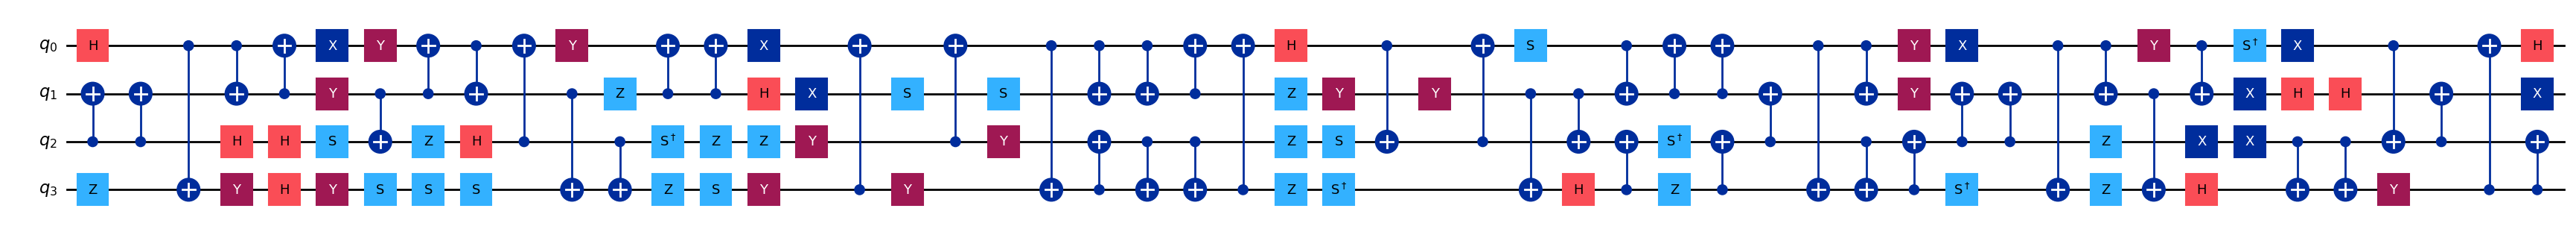

In [36]:
print(len(cliff_circs))
cliff_circs[-1].draw("mpl", fold=-1)

In [37]:
cx_counts = [circ.count_ops().get("cx", 0) for circ in cliff_circs]
avg_cx = float(np.mean(cx_counts))
print(f"\n⇒ Average CX count over {num_circs} circuits: {avg_cx:.2f}")


⇒ Average CX count over 1 circuits: 49.00


In [38]:
# # collect depths
depths = []
for idx, circ in enumerate(cliff_circs, start=1):
    d = circ.depth()
    print(f"Circuit {idx} depth: {d}")
    depths.append(d)

# compute average
avg_depth = sum(depths) / len(depths)
print(f"\nAverage circuit depth over {len(depths)} runs: {avg_depth:.2f}")

Circuit 1 depth: 40

Average circuit depth over 1 runs: 40.00


In [39]:
ideal_expectations = []
for circ in cliff_circs:
    ideal_expect = get_ideal_expectation(circ, pauli_string)
    ideal_expectations.append(ideal_expect)

print(ideal_expectations)

[(0.999999999999998+0j)]


In [40]:
pcs_circs = [[] for _ in range(num_circs)]
signs_list = [[] for _ in range(num_circs)]

for i, circ in enumerate(cliff_circs):
    print("i =", i+1, "out of", num_circs)
    for check_id in range(1, num_checks + 1):
        print("check_id =", check_id)
        sign, pcs_circ = convert_to_PCS_circ(circ, num_qubits, check_id, only_Z_checks=only_Z_checks, barriers=True)
        pcs_circs[i].append(pcs_circ)
        signs_list[i].append(sign)

print(len(pcs_circs))
print(len(pcs_circs[0]))
# print(signs_list)

# pcs_circs[0][0].draw("mpl", fold=-1)

i = 1 out of 1
check_id = 1
check_id = 2
check_id = 3
1
3


# Run Tests

In [41]:
# ————————————————————————————————————————————————————
# ZNE benchmarking 
# ————————————————————————————————————————————————————

# List of ZNE methods and parameters
# zne_methods_list    = ["linear", "richardson"]
zne_methods_list = ["richardson"]
scale_factors_list  = [
    # [1, 1.1, 1.2],
    # [1, 1.2, 1.6],
    # [1, 3, 5],
    [1, 2, 3, 4, 5],
    [1, 3, 5, 7, 9],
    # [1, 1.1, 1.2, 1.3, 1.4],
    # [1, 1.2, 1.5, 1.8, 2]
]
scale_factors_list=[]
fold_methods_list   = [zne.scaling.fold_global]
zne_avg_errors      = {}

# total number of runs = methods × scales × folds × circuits
total_runs = (
    len(zne_methods_list)
    * len(scale_factors_list)
    * len(fold_methods_list)
    * len(cliff_circs)
)

zne_avg_errors = {}
pbar = tqdm(total=total_runs, desc="ZNE benchmarking", position=0)

for zne_m in zne_methods_list:
    for scale_factors in scale_factors_list:
        # skip bad combos
        if zne_m == "richardson" and not all(isinstance(sf, int) for sf in scale_factors):
            continue
        for fold_method in fold_methods_list:
            # run through each circuit
            zne_shots_per_circ = total_shot_budget // len(scale_factors)
            print("shots per circuit: ", zne_shots_per_circ)
            zne_abs_errors = []
            for idx, circ in enumerate(cliff_circs):
                # update the top‐level bar’s description on the fly
                pbar.set_postfix(
                    method=zne_m,
                    scales=scale_factors,
                    fold=fold_method.__name__,
                    circuit=idx+1
                )

                # do the mitigation
                zne_exp = mitigate_zne(
                    circ,
                    backend=backend,
                    pauli_string=pauli_string,
                    shots=zne_shots_per_circ,
                    method=zne_m,
                    scale_factors=scale_factors,
                    fold_method=fold_method
                )
                err = abs(ideal_expectations[idx] - zne_exp)
                zne_abs_errors.append(err)

                pbar.update()   # one step per circuit

            # after you finish this combo
            key = f"ZNE_{zne_m}_{'_'.join(map(str, scale_factors))}_{fold_method.__name__}"
            zne_avg_errors[key] = np.mean(zne_abs_errors)

pbar.close()
print("Final ZNE results:", zne_avg_errors)

ZNE benchmarking: 0it [00:00, ?it/s]

Final ZNE results: {}


PCE methods:   0%|          | 0/2 [00:00<?, ?it/s]


Processing PCE with method: linear


Circuits:   0%|          | 0/1 [00:00<?, ?it/s]

Checks:   0%|          | 0/3 [00:00<?, ?it/s]

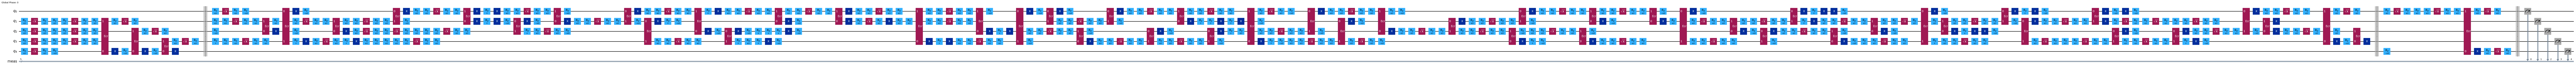

>>> Circuit ops (ISA): OrderedDict({'rz': 350, 'x': 77, 'sx': 75, 'ecr': 53, 'measure': 5, 'barrier': 3})
>>> gate twirling is turned on: True
>>> trex twriing is turned on: True


/opt/anaconda3/envs/qiskit_cloud_test/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'twirling': {'enable_gates': True, 'enable_measure': True, 'shots_per_randomization': 'auto', 'strategy': 'active-circuit'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


num checks =  1
post selection rate:  0.8318261689452706
number of filtered counts:  19409


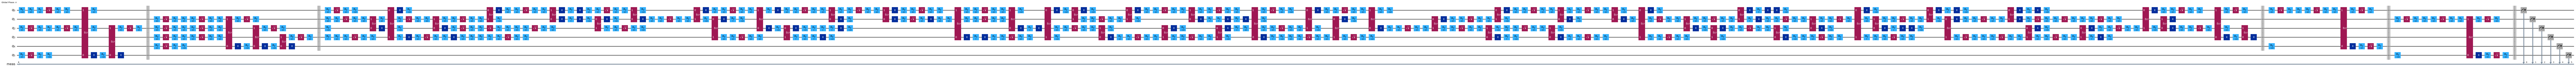

>>> Circuit ops (ISA): OrderedDict({'rz': 379, 'sx': 84, 'x': 80, 'ecr': 56, 'measure': 6, 'barrier': 5})
>>> gate twirling is turned on: True
>>> trex twriing is turned on: True
num checks =  2
post selection rate:  0.6358376548236403
number of filtered counts:  14836


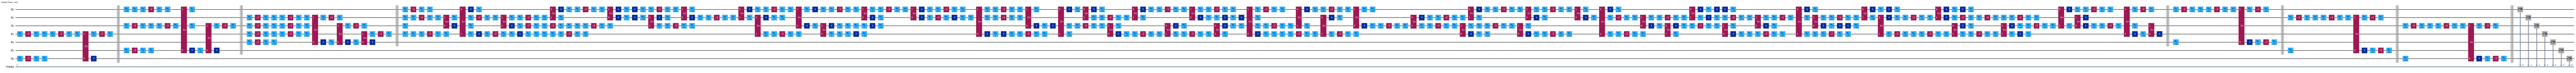

>>> Circuit ops (ISA): OrderedDict({'rz': 401, 'sx': 92, 'x': 82, 'ecr': 58, 'barrier': 7, 'measure': 7})
>>> gate twirling is turned on: True
>>> trex twriing is turned on: True
num checks =  3
post selection rate:  0.579908284404063
number of filtered counts:  13531


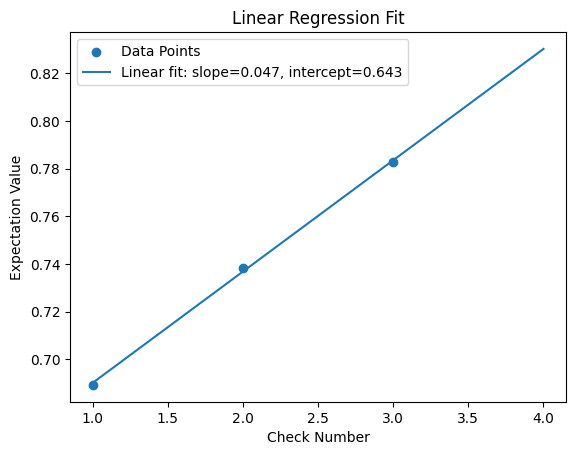

  Circuit 1/1: PCE exp=0.83031, err=0.16969

Average abs error for PCE_linear: 0.16969


Processing PCE with method: exponential


Circuits:   0%|          | 0/1 [00:00<?, ?it/s]

Checks:   0%|          | 0/3 [00:00<?, ?it/s]

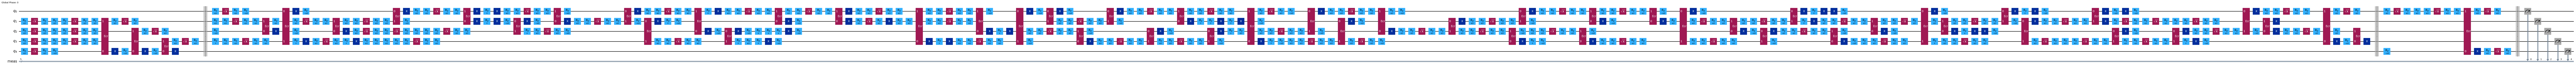

>>> Circuit ops (ISA): OrderedDict({'rz': 350, 'x': 77, 'sx': 75, 'ecr': 53, 'measure': 5, 'barrier': 3})
>>> gate twirling is turned on: True
>>> trex twriing is turned on: True
num checks =  1
post selection rate:  0.8345262075172503
number of filtered counts:  19472


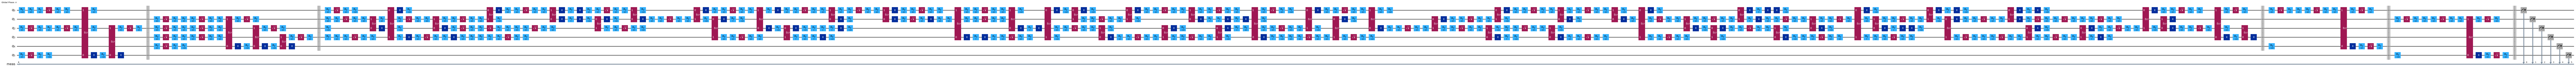

>>> Circuit ops (ISA): OrderedDict({'rz': 379, 'sx': 84, 'x': 80, 'ecr': 56, 'measure': 6, 'barrier': 5})
>>> gate twirling is turned on: True
>>> trex twriing is turned on: True
num checks =  2
post selection rate:  0.6394377062529465
number of filtered counts:  14920


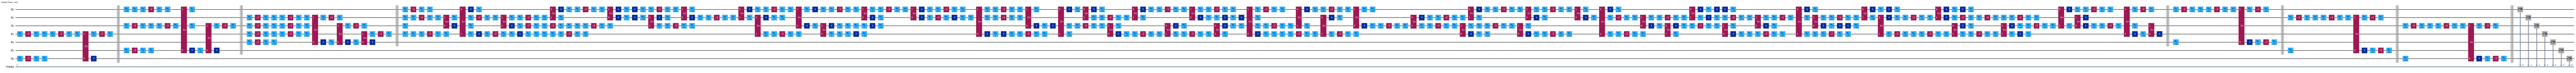

>>> Circuit ops (ISA): OrderedDict({'rz': 401, 'sx': 92, 'x': 82, 'ecr': 58, 'barrier': 7, 'measure': 7})
>>> gate twirling is turned on: True
>>> trex twriing is turned on: True
num checks =  3
post selection rate:  0.5891227017528822
number of filtered counts:  13746


/Users/quinn.langfitt/git/PCS_ZNE/utils/pce_vs_zne_utils.py:589: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_model, check_numbers, y_data, p0=initial_guess,


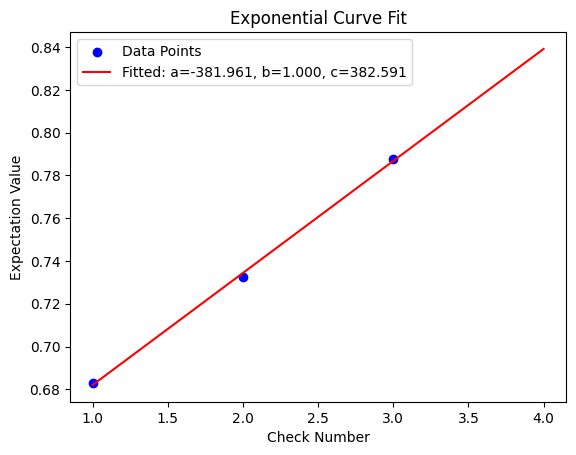

  Circuit 1/1: PCE exp=0.83915, err=0.16085

Average abs error for PCE_exponential: 0.16085

Final PCE results:
{'PCE_linear': 0.16969135612666142, 'PCE_exponential': 0.1608461439277542}


In [42]:
# ————————————————————————————————————————————————————
# PCE benchmarking 
# ————————————————————————————————————————————————————

extrapolation_methods = ["linear", "exponential"]
pce_avg_errors        = {}

for ext_method in tqdm(extrapolation_methods, desc="PCE methods"):
    pce_abs_errors = []
    tqdm.write(f"\nProcessing PCE with method: {ext_method}")

    for i, _ in enumerate(tqdm(cliff_circs, desc="Circuits", leave=False)):
        # collect expectation values for each number of checks
        evs = []
        for j in tqdm(range(num_checks), desc="Checks", leave=False):
            pcs_circ = pcs_circs[i][j]
            signs    = signs_list[i][j]
            ev = ibmq_executor_pcs(
                pcs_circ,
                backend=backend,
                pauli_string=pauli_string,
                num_qubits=num_qubits,
                shots=shots_per_check,
                signs=signs
            )
            evs.append(ev)

        # extrapolate
        extrap_vals, _ = extrapolate_checks(
            num_checks,
            extrap_checks,
            evs,
            method=ext_method
        )
        pce_exp = extrap_vals[-1]
        ideal   = ideal_expectations[i]
        err     = abs(ideal - pce_exp)

        tqdm.write(f"  Circuit {i+1}/{num_circs}: PCE exp={pce_exp:.5f}, err={err:.5f}")
        pce_abs_errors.append(err)

    avg_err = np.mean(pce_abs_errors)
    key     = f"PCE_{ext_method}"
    pce_avg_errors[key] = avg_err
    tqdm.write(f"\nAverage abs error for {key}: {avg_err:.5f}\n")

tqdm.write("Final PCE results:")
tqdm.write(str(pce_avg_errors))

In [43]:
evs

[0.6831347576006573, 0.7323056300268097, 0.7878655608904409]

In [44]:
# Combine all errors in a single dictionary
avg_errors = zne_avg_errors.copy()
avg_errors.update(pce_avg_errors)

print(avg_errors)

{'PCE_linear': 0.16969135612666142, 'PCE_exponential': 0.1608461439277542}


In [45]:
# circ_folder = "data_PCE_vs_ZNE/rand_cliffs"
# file_name = (
#     f"avg_errors_n={num_qubits}"
#     f"_d={circuit_depth}"
#     f"_num_circs={num_circs}"
#     f"_num_samp={total_shot_budget}"
#     f"_avgCXcount={avg_cx:.2f}"
#     f"_avgDepth={avg_depth:.2f}.csv"
# )
# save_avg_errors(circ_folder, file_name, avg_errors, overwrite=False)